In [41]:
import numpy as np
from math import sqrt
import datetime
import csv
import matplotlib.pyplot as plt
import json
from pyspark.mllib.clustering import KMeans, KMeansModel

In [28]:
with open('data/detroit.csv') as f:
    csv_file = csv.reader(f)
    next(csv_file)
    crime_list = []
    for row in csv_file:
        crime_list.append(row)

In [29]:
data = []
for row in crime_list:
    crime_date = datetime.datetime.strptime(row[2], '%m/%d/%Y').date()
    crime_pos  = np.array([float(row[-2]), float(row[-1])])
    crime_type = row[3].split('-')[0].strip()
    crime_type = crime_type.split(',')[0].strip()
    crime_type = crime_type.split('(')[0].strip()
    data.append([crime_date, crime_pos, crime_type])

In [30]:
data_rdd = sc.parallelize(data)
histogram_year_rdd = data_rdd.map(lambda x: (x[0].month, 1)).reduceByKey(lambda x, y: x + y).sortByKey()
year_count = histogram_year_rdd.collect()
histogram_category_rdd = data_rdd.map(lambda x: (x[2], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: -x[1])
category_count = histogram_category_rdd.collect()

<Container object of 12 artists>

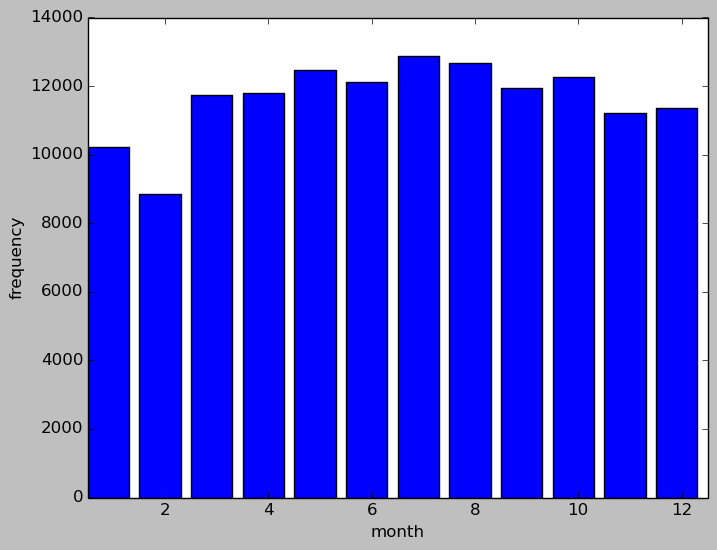

In [31]:
month = [x[0] - 0.5 for x in year_count]
freq = [x[1] for x in year_count]
plt.xlabel('month')
plt.ylabel('frequency')
plt.xlim([0.5,12.5])
plt.bar(month, freq)

<Container object of 211 artists>

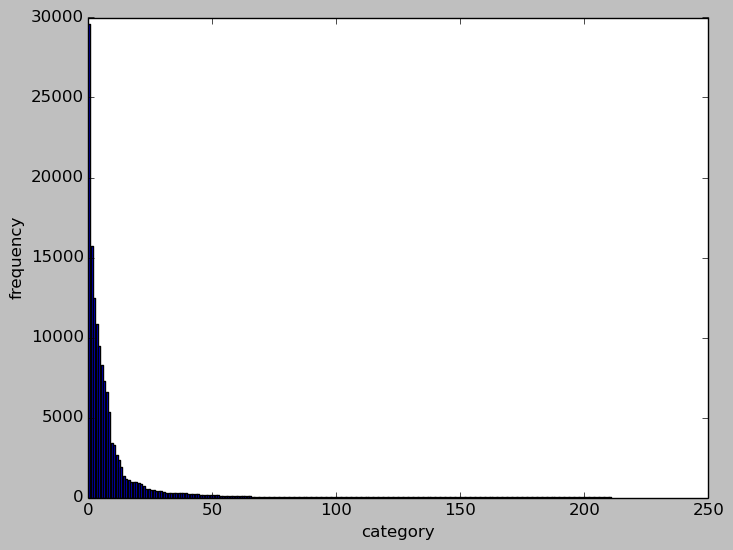

In [32]:
category = [x for x in category_count]
freq = [x[1] for x in category_count]
plt.xlabel('category')
plt.ylabel('frequency')
plt.bar(range(len(category)),freq)

In [8]:
def selection(item, choices):
    return len(choices) == 0 or item in choices

In [9]:
def cluster(date_range, category_types, num_clusters):
    #Label data
    filtered_rdd = data_rdd.filter(lambda x: selection(x[0].month, date_range) and selection(x[2], category_types))
    pos_rdd = filtered_rdd.map(lambda x: x[1])
    clusters = KMeans.train(pos_rdd, num_clusters, maxIterations=100, initializationMode="random")
    label_rdd = pos_rdd.map(lambda x: [x, clusters.centers[clusters.predict(x)]])
    
    #Cluster and distribution
    return label_rdd, clusters

In [10]:
def sse(point, center):
    return sqrt(sum([i**2 for i in (point - center)]))

In [35]:
crime_category = [
    'LARCENY',
    'ASSAULT AND BATTERY/SIMPLE ASSAULT',
    'DAMAGE TO PROPERTY',
    'BURGLARY',
    'AGG/FEL ASSAULT',
    'VEHICLE THEFT',
    'WARRANTS',
    'FRAUD',
    'ROBBERY',
    'TELEPHONE USED FOR HARASSMENT',
]

def danger_rdd(months, categories, num_clusters):
    label, centers = cluster(months, categories, num_clusters)
    center_to_errors= label.map(lambda x: (tuple(x[1]),[sse(x[0],x[1])])).reduceByKey(lambda a,b: a+b)
    #[[center,mean,std,count]...]
    center_info= center_to_errors.map(lambda entry:[entry[0],np.mean(entry[1]),np.std(entry[1]),len(entry[1])])
    return center_info

danger_zones = []
# All categories combined together
danger_zones.append(danger_rdd([], [], 10).collect())
# Do k-means for each of the category
for i in crime_category:
    danger_zones.append(danger_rdd([], [i], 10).collect())

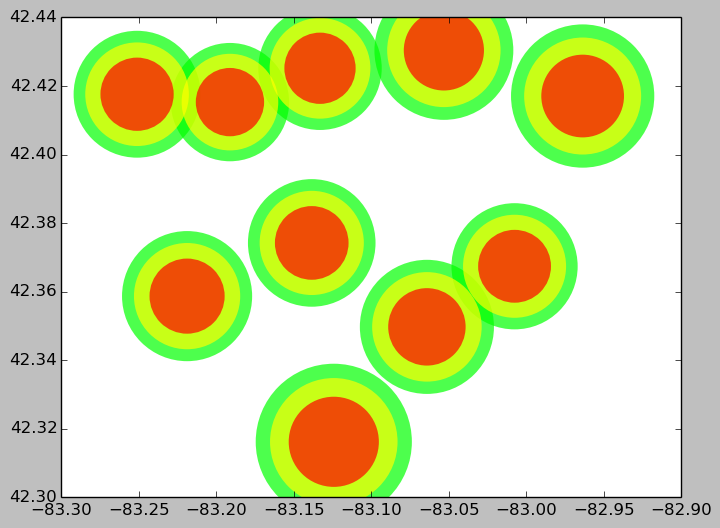

In [36]:
def plot_danger_zone(danger_zone):
    scale = 300000
    danger_zone[0][0]
    colors = [np.array([1, 0, 0, 0.7]), np.array([1, 1, 0, 0.7]), np.array([0, 1, 0, 0.7])]
#     colors = ['red', 'green', 'blue']
    longitudes = [d[0][1] for d in danger_zone]
    latitudes = [d[0][0] for d in danger_zone]
    # 3 SD
    size_green = [(d[2] * 3 * scale) for d in danger_zone]
    plt.scatter(longitudes, latitudes, s=size_green, c=colors[2], edgecolors='none')
    # 2 SD
    size_yellow = [(d[2] * 2 * scale) for d in danger_zone]
    plt.scatter(longitudes, latitudes, s=size_yellow, c=colors[1], edgecolors='none')
    # 1 SD
    size_red = [(d[2] * 1 * scale) for d in danger_zone]
    plt.scatter(longitudes, latitudes, s=size_red, c=colors[0], edgecolors='none')
    plt.show()
# plot the heat spots of all categories just for example
plot_danger_zone(danger_zones[0])

In [40]:
# Save output file to json file, plot on local machine
with open('danger_zones.json', mode='w') as f:
    json.dump(danger_zones, f, indent=4)

NameError: name 'json' is not defined